In [8]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [16]:
path = 'https://raw.githubusercontent.com/FabioHodo/EIB2_ClimateRisk/main/cleaned%20data/data_imputed/imputed_knn/'
df = pd.read_csv(path +'Emissions_GHG_(fromCAIT).csv',index_col='Unnamed: 0' )
df 

,Country,Code,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Albania,ALB,11.40,9.04,6.99,6.93,7.77,7.53,7.25,6.54,...,8.54,8.60,8.88,9.33,8.94,9.05,9.54,9.48,9.33,9.90
1,Algeria,DZA,96.00,94.87,94.50,102.03,99.78,103.99,105.30,109.39,...,156.40,166.21,167.32,179.68,189.89,193.59,203.79,211.66,209.41,211.50
2,Angola,AGO,150.61,151.28,151.61,152.39,152.54,156.90,161.39,156.01,...,173.99,180.66,186.83,220.92,185.95,203.34,185.10,207.66,182.19,176.85
3,Antigua and Barbuda,ATG,0.34,0.35,0.43,0.41,0.42,0.44,0.47,0.50,...,1.06,2.02,1.13,1.07,1.29,1.06,1.08,1.10,1.14,1.17
4,Argentina,ARG,323.84,328.83,333.22,335.73,340.81,341.39,344.46,346.24,...,468.33,452.69,440.34,450.10,464.88,462.89,456.74,460.21,469.73,469.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,VUT,0.47,0.48,0.50,0.53,0.54,0.54,0.57,0.57,...,0.70,0.70,0.71,0.75,0.75,0.75,0.81,0.81,0.84,0.84
163,Venezuela,VEN,303.14,304.92,308.93,315.26,318.02,326.54,331.00,337.59,...,265.49,261.47,291.82,323.30,343.49,373.61,359.46,352.14,352.08,338.14
164,Vietnam,VNM,25.63,28.49,31.00,37.69,43.31,49.46,56.03,63.80,...,209.45,231.71,251.16,235.76,237.24,249.25,263.12,306.26,320.67,319.54
165,Zambia,ZMB,485.43,484.96,484.28,483.00,481.44,478.95,444.46,405.54,...,471.05,412.65,460.49,432.46,455.21,468.32,440.83,473.30,495.17,495.99


In [23]:
def makeMonthly(country, scale = 20):
    '''
    Turn the yearly data into monthly using Brownian bridge algorithm
    Parameter:
        country: a string for the country name
        scale: an integer for the data scaling
    Return:
        the scaled monthly data
    '''
    #AnnualVal = Albania.loc["1990":"2017"]
    AnnualVal = country*scale
    n = (len(AnnualVal)-1)*12
    monthly = np.zeros(n+1)
    monthlyVal = np.zeros(n)
    for i in range(1, len(AnnualVal)+1):
        monthly[(i-1)*12] = AnnualVal[i-1]

    for i in range(1, len(AnnualVal)): #1-4
        for j in range ((i-1)*12+1, (i)*12): #0 to  47
            monthly[j] = monthly[j-1] + (monthly[(i)*12] - monthly[j-1])*(1/((i*12)-(j-1)))
            + (((i*12-j)*(1)/(i*12-(j-1)))**(1/2))*np.random.randn()
            monthlyVal[j-1] = monthly[j] -monthly[j-1]
    return monthly/scale

In [24]:
def create_dataset(dataset,timestep = 10):
    data_x,data_y = [],[]
    for i in range(len(dataset)-timestep-1):
        a = dataset[i:i+timestep]
        data_x.append(a)
        data_y.append(dataset[i+timestep])
    return np.array(data_x),np.array(data_y)

In [19]:
def predict(num_prediction, model, test_data, look_back):
    prediction_list = test_data[-look_back:]
    
    for i in range(num_prediction):
        x = prediction_list[-look_back:]
        #print(x)
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back:]
        
    return prediction_list

In [25]:
def FuturePrediction(country,look_back,num_prediction):
    '''
    Make prediction for the data of one country to 2030
    Parameter:
        country: a string that specifies the country name
    Return:
        prediction: a list of values for future prediction of the data for each year
    '''
    data = df[df['Country']==country]
    data = data.loc[:,"1990":"2017"].T
    monthly = makeMonthly(np.array(data), 10)
    monthly = np.reshape(monthly, (-1, 1))
    
    # Feature Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(monthly)
    
    #split train and test dataset
    train_size = int(len(data)*0.7)
    test_size = len(data)-train_size
    train_data, test_data = data[0:train_size,:],data[train_size:len(data),:]
    
    x_train, y_train = create_dataset(train_data,timestep = look_back)
    x_test, y_test = create_dataset(test_data,timestep = look_back)
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
    
#     model = Sequential()
#     model.add(LSTM(100, input_shape=(x_train.shape[1], 1)))
#     model.add(Dropout(0.2))
#     model.add(Dense(1, activation = 'relu'))
#     model.compile(loss='mean_squared_error', optimizer='adam')
 
    # Create the Stacked LSTM model
    model = Sequential()

    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

    # model.add(LSTM(units = 50))
    # model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(1, activation = 'relu'))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    model.fit(x_train, y_train, validation_data = (x_test, y_test) ,epochs = 50, batch_size = 20,verbose =1,
             callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

    # Make monthly predictions into the future
    x = predict(num_prediction, model, test_data, look_back)
    prediction = scaler.inverse_transform(x.reshape(-1,1))
    # Make yearly predictions into the future
    annual_prediction = prediction[11:num_prediction:12]
    return annual_prediction

In [26]:
def PredictAll(df,look_back,num_prediction):
    '''
    Make predictions to 2030 for all the countries with valid data
    Parameter:
        df: a dataframe with the data
    Return:
        df: a dataframe with the original data and the predictions
    '''
    countries = df['Country']
    world_prediction = []
    for country in countries:
        #print(FuturePrediction(country,look_back,num_prediction))
        world_prediction.append(FuturePrediction(country,look_back,num_prediction))
    world_prediction = np.squeeze(np.array(world_prediction), axis = (2,))
    years = ['2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
    #print(world_prediction)
    #print(world_prediction.shape)
    #print(world_prediction[:, 1])
    for i in range(len(years)):
        df[years[i]] = world_prediction[:, i]
    return df

In [27]:
ghg_prediction = PredictAll(df[df['Country']=='Argentina'],look_back=10,num_prediction=13*12)
ghg_prediction

Epoch 1/50
11/11 [==============================] - 2s 79ms/step - loss: 0.1890 - val_loss: 0.4058
Epoch 2/50
11/11 [==============================] - 0s 24ms/step - loss: 0.0520 - val_loss: 7.9353e-04
Epoch 3/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0308 - val_loss: 0.0710
Epoch 4/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0172 - val_loss: 6.8332e-04
Epoch 5/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0085 - val_loss: 0.0013
Epoch 6/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 7/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 8/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0069 - val_loss: 0.0021
Epoch 9/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 10/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0037 - val_loss: 7.1592e-

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


,Country,Code,1990,1991,1992,1993,1994,1995,1996,1997,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
4,Argentina,ARG,323.84,328.83,333.22,335.73,340.81,341.39,344.46,346.24,...,529.217101,539.742159,548.071739,554.343128,558.881408,562.069138,564.260598,565.744628,566.739279,567.401337


Epoch 1/50
11/11 [==============================] - 2s 57ms/step - loss: 0.1376 - val_loss: 0.1253
Epoch 2/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0412 - val_loss: 0.0011
Epoch 3/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0256 - val_loss: 0.0127
Epoch 4/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0193 - val_loss: 0.0114
Epoch 5/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0138 - val_loss: 0.0013
Epoch 6/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0101 - val_loss: 0.0064
Epoch 7/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0084 - val_loss: 4.3467e-04
Epoch 8/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0082 - val_loss: 0.0020
Epoch 9/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0067 - val_loss: 0.0047
Epoch 10/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0069 - val_loss: 4.2346e-04
E

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


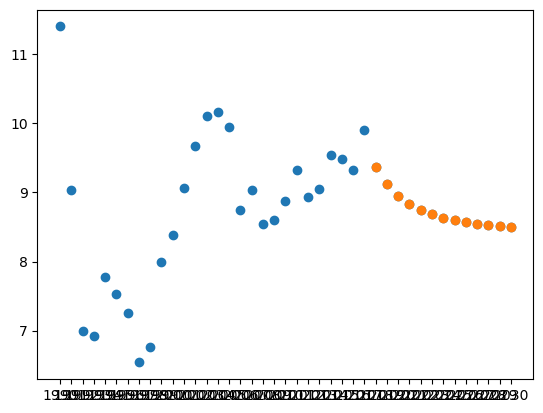

Epoch 1/50
11/11 [==============================] - 2s 62ms/step - loss: 0.0699 - val_loss: 0.4271
Epoch 2/50
11/11 [==============================] - 0s 20ms/step - loss: 0.0264 - val_loss: 0.0849
Epoch 3/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0174 - val_loss: 0.1564
Epoch 4/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0114 - val_loss: 0.0979
Epoch 5/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0080 - val_loss: 0.0238
Epoch 6/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0043 - val_loss: 0.0124
Epoch 7/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 6.4174e-04
Epoch 8/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0016 - val_loss: 0.0045
Epoch 9/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 10/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


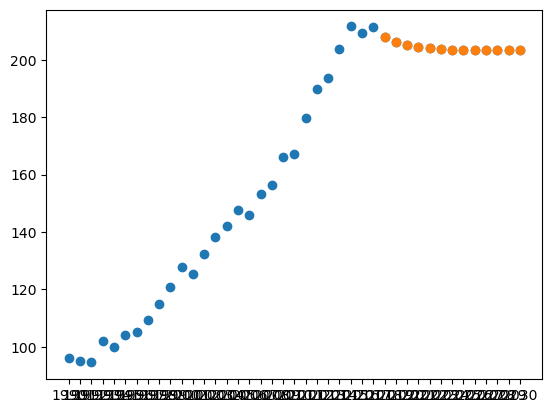

Epoch 1/50
11/11 [==============================] - 2s 66ms/step - loss: 0.0835 - val_loss: 0.2344
Epoch 2/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0277 - val_loss: 0.0264
Epoch 3/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0209 - val_loss: 0.0757
Epoch 4/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0149 - val_loss: 0.0508
Epoch 5/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0113 - val_loss: 0.0212
Epoch 6/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0088 - val_loss: 0.0187
Epoch 7/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0065 - val_loss: 0.0095
Epoch 8/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0047 - val_loss: 0.0091
Epoch 9/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0038 - val_loss: 0.0088
Epoch 10/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0042 - val_loss: 0.0090
Epoch 11/

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


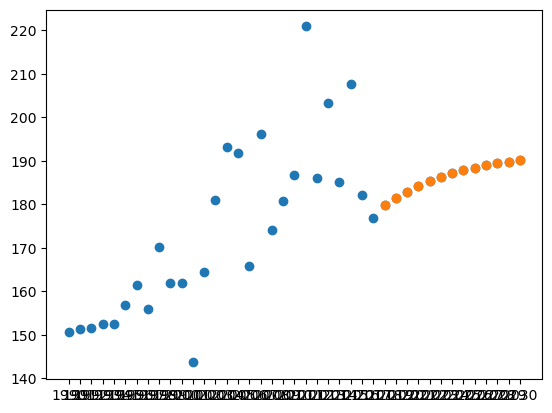

Epoch 1/50
11/11 [==============================] - 2s 63ms/step - loss: 0.0394 - val_loss: 0.0879
Epoch 2/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0196 - val_loss: 0.0180
Epoch 3/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0159 - val_loss: 0.0568
Epoch 4/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0134 - val_loss: 0.0250
Epoch 5/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0104 - val_loss: 0.0150
Epoch 6/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0077 - val_loss: 0.0066
Epoch 7/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 8/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0018 - val_loss: 0.0241
Epoch 9/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0331
Epoch 10/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0027 - val_loss: 0.0088
Epoch 11/

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


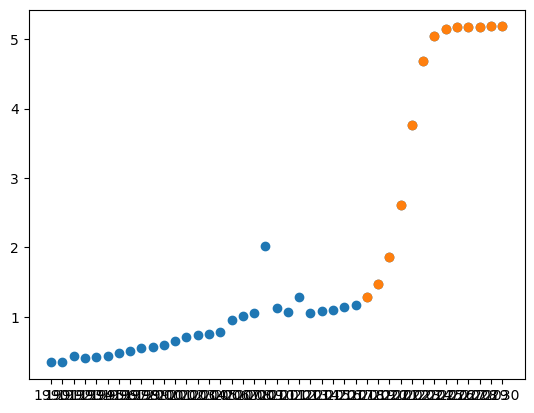

Epoch 1/50
11/11 [==============================] - 2s 70ms/step - loss: 0.1889 - val_loss: 0.4832
Epoch 2/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0827 - val_loss: 0.0604
Epoch 3/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0354 - val_loss: 0.0178
Epoch 4/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0226 - val_loss: 0.0269
Epoch 5/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0115 - val_loss: 5.9005e-04
Epoch 6/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0063 - val_loss: 5.9213e-04
Epoch 7/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 8/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 9/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0053 - val_loss: 4.9184e-04
Epoch 10/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0044 - val_loss: 5.15

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


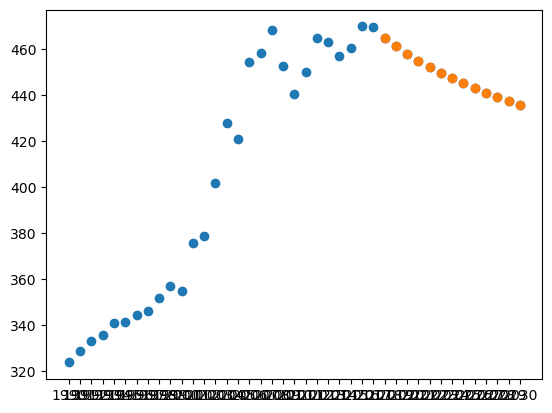

Epoch 1/50
11/11 [==============================] - 2s 68ms/step - loss: 0.0621 - val_loss: 0.0062
Epoch 2/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0395 - val_loss: 0.0011
Epoch 3/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0260 - val_loss: 2.7071e-04
Epoch 4/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0127 - val_loss: 1.7005e-04
Epoch 5/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 6/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0048 - val_loss: 0.0064
Epoch 7/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0029 - val_loss: 1.2202e-04
Epoch 8/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 9/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 5.2221e-04
Epoch 10/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0025 - val_loss: 

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


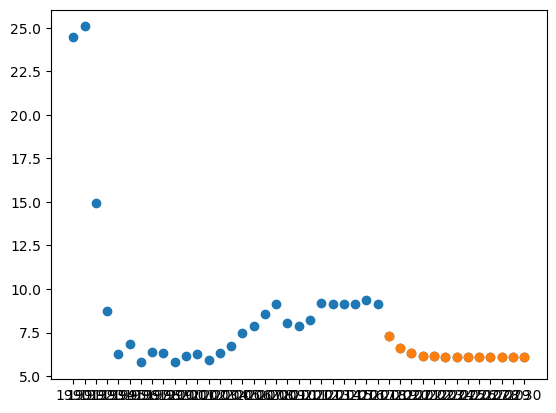

Epoch 1/50
11/11 [==============================] - 2s 69ms/step - loss: 0.2038 - val_loss: 0.0495
Epoch 2/50
11/11 [==============================] - 0s 22ms/step - loss: 0.1063 - val_loss: 0.0198
Epoch 3/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0405 - val_loss: 0.0515
Epoch 4/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0300 - val_loss: 0.0127
Epoch 5/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0153 - val_loss: 0.0101
Epoch 6/50
11/11 [==============================] - 0s 20ms/step - loss: 0.0082 - val_loss: 0.0046
Epoch 7/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0085 - val_loss: 0.0041
Epoch 8/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 9/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0086 - val_loss: 0.0043
Epoch 10/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 11/

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


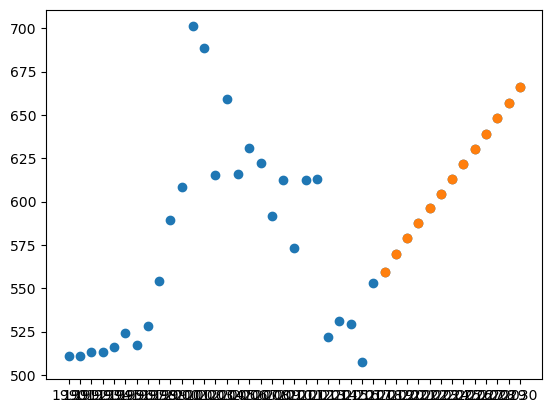

Epoch 1/50
11/11 [==============================] - 2s 75ms/step - loss: 0.2685 - val_loss: 0.1016
Epoch 2/50
11/11 [==============================] - 0s 20ms/step - loss: 0.0883 - val_loss: 0.0217
Epoch 3/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0419 - val_loss: 0.0040
Epoch 4/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0264 - val_loss: 0.0041
Epoch 5/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0182 - val_loss: 0.0043
Epoch 6/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0107 - val_loss: 0.0019
Epoch 7/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0090 - val_loss: 0.0018
Epoch 8/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0091 - val_loss: 0.0019
Epoch 9/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0082 - val_loss: 0.0020
Epoch 10/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0074 - val_loss: 0.0019
Epoch 11/

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


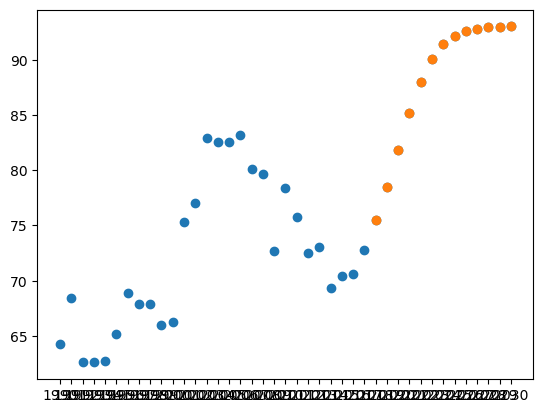

Epoch 1/50
11/11 [==============================] - 2s 74ms/step - loss: 0.0815 - val_loss: 0.3773
Epoch 2/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0815 - val_loss: 0.3773
Epoch 3/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0748 - val_loss: 0.2740
Epoch 4/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0309 - val_loss: 0.0369
Epoch 5/50
11/11 [==============================] - 0s 20ms/step - loss: 0.0237 - val_loss: 0.0623
Epoch 6/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0139 - val_loss: 0.0178
Epoch 7/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0069 - val_loss: 0.0018
Epoch 8/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0070 - val_loss: 0.0047
Epoch 9/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 10/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0057 - val_loss: 0.0081
Epoch 11/

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


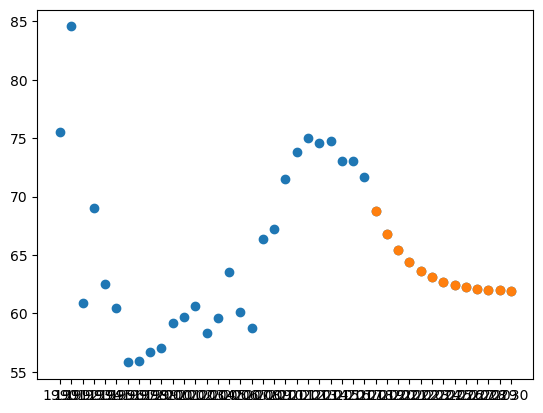

Epoch 1/50
11/11 [==============================] - 2s 75ms/step - loss: 0.0610 - val_loss: 0.0393
Epoch 2/50
11/11 [==============================] - 0s 21ms/step - loss: 0.0278 - val_loss: 0.0047
Epoch 3/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0161 - val_loss: 0.0014
Epoch 4/50
11/11 [==============================] - 0s 20ms/step - loss: 0.0042 - val_loss: 0.0077
Epoch 5/50
11/11 [==============================] - 0s 20ms/step - loss: 0.0034 - val_loss: 0.0121
Epoch 6/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0029 - val_loss: 0.0056
Epoch 7/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0027 - val_loss: 0.0073
Epoch 8/50
11/11 [==============================] - 0s 19ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 9/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0030 - val_loss: 0.0057
Epoch 10/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0030 - val_loss: 0.0067
Epoch 11/

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


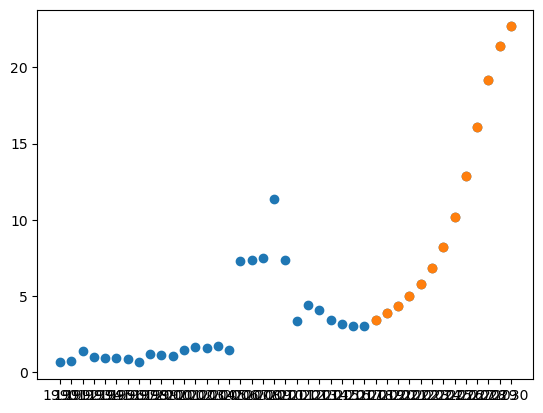

In [28]:
for i in range(10):
    df_pt = df[df['Country']==df['Country'][i]]
    ghg_prediction = PredictAll(df_pt,look_back=6,num_prediction=13*12)
    df2 =  df_pt.iloc[:,2:]
    plt.scatter(df2.columns,df2)
    df3 = ghg_prediction.iloc[:,-13:]
    plt.scatter(df3.columns,df3)
    plt.show()

# Compare with unstacked LSTM

In [29]:
def FuturePrediction(country,look_back,num_prediction):
    '''
    Make prediction for the data of one country to 2030
    Parameter:
        country: a string that specifies the country name
    Return:
        prediction: a list of values for future prediction of the data for each year
    '''
    data = df[df['Country']==country]
    data = data.loc[:,"1990":"2017"].T
    monthly = makeMonthly(np.array(data), 10)
    monthly = np.reshape(monthly, (-1, 1))
    
    # Feature Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(monthly)
    
    #split train and test dataset
    train_size = int(len(data)*0.7)
    test_size = len(data)-train_size
    train_data, test_data = data[0:train_size,:],data[train_size:len(data),:]
    
    x_train, y_train = create_dataset(train_data,timestep = look_back)
    x_test, y_test = create_dataset(test_data,timestep = look_back)
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
    
    model = Sequential()
    model.add(LSTM(100, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
 
    # Create the Stacked LSTM model
#     model = Sequential()

#     model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
#     model.add(Dropout(0.2))

#     model.add(LSTM(units = 50, return_sequences = True))
#     model.add(Dropout(0.2))

#     model.add(LSTM(units = 50))
#     model.add(Dropout(0.2))

    # model.add(LSTM(units = 50))
    # model.add(Dropout(0.2))
    # Adding the output layer
#     model.add(Dense(1, activation = 'relu'))

    # Compiling the RNN
#     model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    model.fit(x_train, y_train, validation_data = (x_test, y_test) ,epochs = 50, batch_size = 20,verbose =1,
             callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

    # Make monthly predictions into the future
    x = predict(num_prediction, model, test_data, look_back)
    prediction = scaler.inverse_transform(x.reshape(-1,1))
    # Make yearly predictions into the future
    annual_prediction = prediction[11:num_prediction:12]
    return annual_prediction

Epoch 1/50
11/11 [==============================] - 1s 28ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 2/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 2.1667e-04
Epoch 3/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 3.9990e-04
Epoch 4/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 4.7667e-04
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 1.2198e-04
Epoch 7/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 4.3485e-04
Epoch 8/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 7.

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


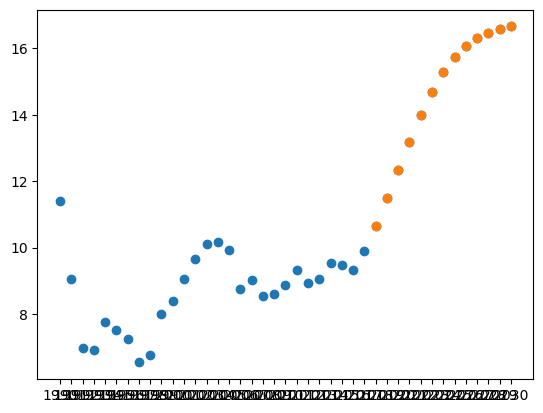

Epoch 1/50
11/11 [==============================] - 1s 31ms/step - loss: 0.0392 - val_loss: 0.0408
Epoch 2/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0061 - val_loss: 0.0112
Epoch 3/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0094
Epoch 4/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 5/50
11/11 [==============================] - 0s 11ms/step - loss: 6.0516e-04 - val_loss: 0.0015
Epoch 6/50
11/11 [==============================] - 0s 10ms/step - loss: 7.7073e-04 - val_loss: 0.0035
Epoch 7/50
11/11 [==============================] - 0s 9ms/step - loss: 5.7406e-04 - val_loss: 0.0036
Epoch 8/50
11/11 [==============================] - 0s 9ms/step - loss: 6.2340e-04 - val_loss: 8.5889e-04
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 5.3936e-04 - val_loss: 0.0060
Epoch 10/50
11/11 [==============================] - 0s 9ms/step - loss: 5.4317e-04 - va

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


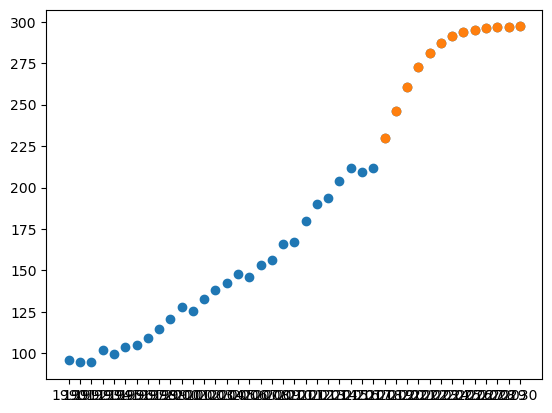

Epoch 1/50
11/11 [==============================] - 1s 29ms/step - loss: 0.0606 - val_loss: 0.0435
Epoch 2/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0096 - val_loss: 0.0091
Epoch 3/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0059 - val_loss: 0.0186
Epoch 4/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0037 - val_loss: 0.0058
Epoch 5/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0062
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0063
Epoch 7/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0064
Epoch 8/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0057
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0053
Epoch 10/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0056
Epoch 11/50
11/

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


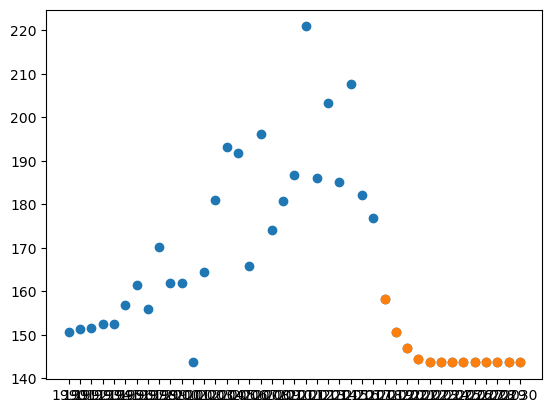

Epoch 1/50
11/11 [==============================] - 1s 31ms/step - loss: 0.0590 - val_loss: 0.2363
Epoch 2/50
11/11 [==============================] - 0s 12ms/step - loss: 0.0505 - val_loss: 0.1038
Epoch 3/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0126 - val_loss: 0.0022
Epoch 4/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 5/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0256
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 6.8303e-04 - val_loss: 0.0178
Epoch 7/50
11/11 [==============================] - 0s 10ms/step - loss: 8.5464e-04 - val_loss: 0.0122
Epoch 8/50
11/11 [==============================] - 0s 9ms/step - loss: 4.5772e-04 - val_loss: 0.0133
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 7.8125e-04 - val_loss: 0.0137
Epoch 10/50
11/11 [==============================] - 0s 9ms/step - loss: 6.9063e-04 - val_loss: 0

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


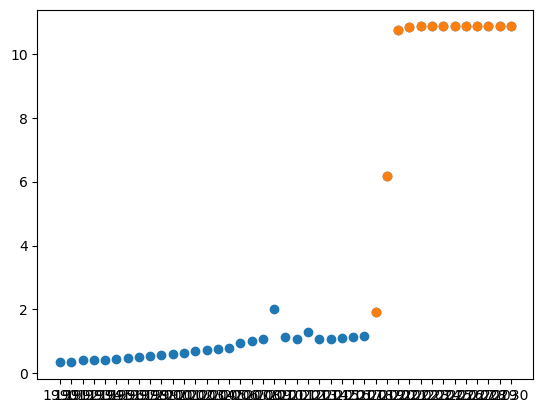

Epoch 1/50
11/11 [==============================] - 1s 44ms/step - loss: 0.1150 - val_loss: 0.0251
Epoch 2/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0164 - val_loss: 3.0586e-04
Epoch 3/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0063 - val_loss: 0.0141
Epoch 4/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 5/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 7.8651e-04
Epoch 6/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 7/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 2.7127e-04
Epoch 8/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 9/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 3.4976e-04
Epoch 10/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 6.

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


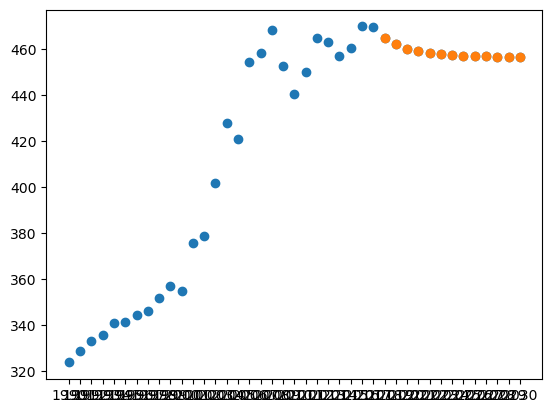

Epoch 1/50
11/11 [==============================] - 1s 33ms/step - loss: 0.0322 - val_loss: 4.7719e-04
Epoch 2/50
11/11 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 6.5832e-05
Epoch 3/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 4/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 5/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 5.0445e-04
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 8.9718e-04 - val_loss: 3.4631e-04
Epoch 7/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 6.9947e-04
Epoch 8/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 9.5236e-04
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 8.0857e-04 - val_loss: 5.6770e-04
Epoch 10/50
11/11 [==============================] - 0s 9ms/step - loss: 7.939

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


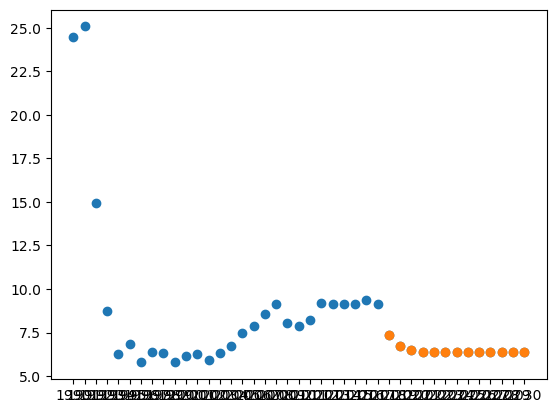

Epoch 1/50
11/11 [==============================] - 1s 31ms/step - loss: 0.2060 - val_loss: 0.0295
Epoch 2/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0370 - val_loss: 0.0312
Epoch 3/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0131 - val_loss: 0.0046
Epoch 4/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0083 - val_loss: 0.0041
Epoch 5/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 7/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 8/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 10/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 11/50
11/

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


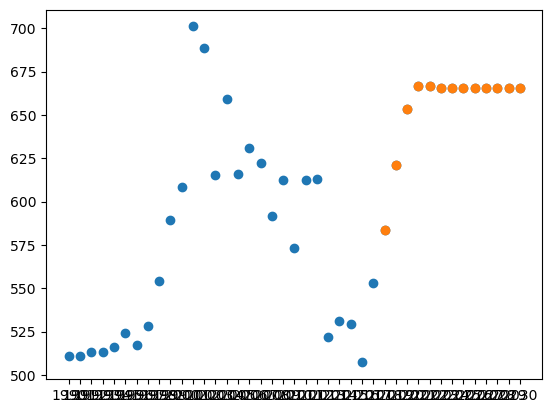

Epoch 1/50
11/11 [==============================] - 1s 32ms/step - loss: 0.1638 - val_loss: 0.0059
Epoch 2/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0248 - val_loss: 0.0051
Epoch 3/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0108 - val_loss: 0.0037
Epoch 4/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0073 - val_loss: 0.0040
Epoch 5/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 6/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 7/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 8/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 9/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 10/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 11/50


<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


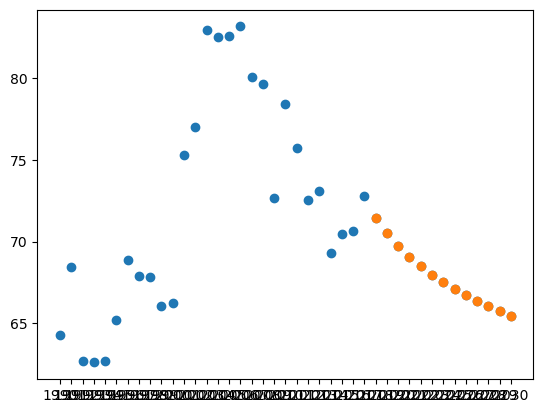

Epoch 1/50
11/11 [==============================] - 1s 32ms/step - loss: 0.0396 - val_loss: 0.0281
Epoch 2/50
11/11 [==============================] - 0s 14ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 3/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0045 - val_loss: 0.0060
Epoch 4/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0045 - val_loss: 3.7974e-04
Epoch 5/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0041 - val_loss: 0.0102
Epoch 6/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 7.6962e-04
Epoch 7/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0088
Epoch 8/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 9.1436e-04
Epoch 9/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0062
Epoch 10/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0035 - val_loss: 0.004

<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


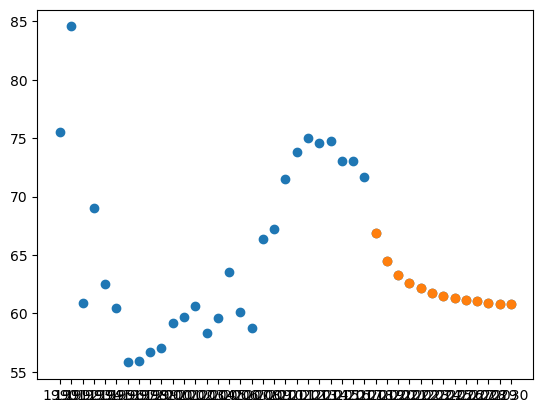

Epoch 1/50
11/11 [==============================] - 1s 32ms/step - loss: 0.0404 - val_loss: 0.0022
Epoch 2/50
11/11 [==============================] - 0s 13ms/step - loss: 0.0085 - val_loss: 0.0040
Epoch 3/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0107
Epoch 4/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0052
Epoch 5/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0058
Epoch 7/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 8/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0085
Epoch 10/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 11/50


<ipython-input-26-2e4cef30889d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[years[i]] = world_prediction[:, i]


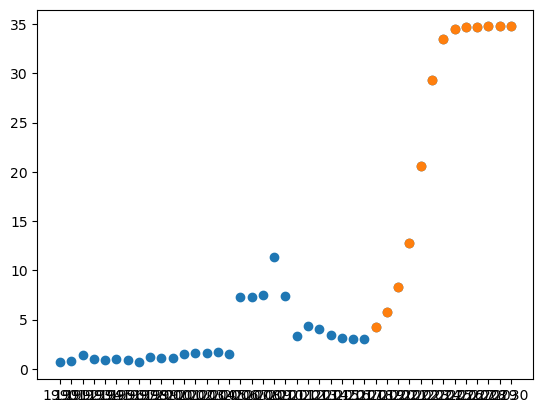

In [30]:
for i in range(10):
    df_pt = df[df['Country']==df['Country'][i]]
    ghg_prediction = PredictAll(df_pt,look_back=6,num_prediction=13*12)
    df2 =  df_pt.iloc[:,2:]
    plt.scatter(df2.columns,df2)
    df3 = ghg_prediction.iloc[:,-13:]
    plt.scatter(df3.columns,df3)
    plt.show()